# Data cleaning and exploration

---
**Data Fields**

*  *Tweet* - This is the text that was tweeted
*  *following* -The number of people the account that tweeted is following
*  *followers* - The number of people following the account that tweeted
*  *actions* - The total number of favorites, replies, and retweets of said tweet
*  *is_retweet* - Binary [0,1] value: If 0 its not a retweet, if 1 it is a retweet
*  *location* - The self-written location provided by the user on their profile, May not exist, be "Unkown", and is NOT standardized! ex. could be ("NY", "New York", "Upper East Side", Etc!)

*  *Type* - Either Quality or Spam





[Link para o dataset](https://www.kaggle.com/c/utkmls-twitter-spam-detection-competition/data?select=sample_submission.csv)

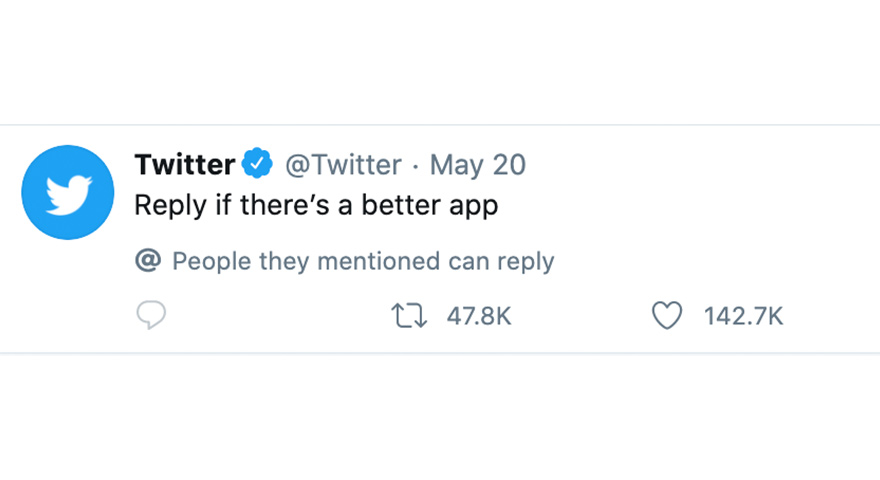

In [1]:
import pandas as pd
#open the dataframe using pandas
train_df = pd.read_csv('model/dataset/train-tweets.csv', delimiter= ',', header = 0)
test_df = pd.read_csv('model/dataset/test-tweets.csv')

train_df = train_df.drop('Unnamed: 7', axis=1)
train_df = train_df.drop('location', axis=1)
train_df.head()

,Tweet,following,followers,actions,is_retweet,Type
0,Good Morning Love @LeeBrown_V,0.0,0.0,0.0,0.0,Quality
1,'@realDonaldTrump @USNavy RIP TO HEROES',42096.0,61060.0,5001.0,0.0,Spam
2,Haven't been following the news but I understa...,0.0,0.0,NaN,0.0,Quality
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0,0.0,0.0,0.0,Quality
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,17800.0,35100.0,NaN,0.0,Quality


In [2]:
test_df = test_df.drop('Id', axis=1)
test_df = test_df.drop('location', axis=1)
test_df.head()

,Tweet,following,followers,actions,is_retweet
0,"Cops shoot blacks almost everyday, and there a...",5509.0,5977.0,8062.0,1
1,"#HAPPYTAEYANGDAY Oppa,happy birthday to you, ...",0.0,0.0,NaN,0
2,RT @HoneyBadger10: Panthers in the super bowl....,471.0,229.0,747.0,0
3,Sorry my Twitter keeps posting my retweets a m...,0.0,79800.0,48.0,0
4,Heart attack causes and symptoms are different...,902.0,5797.0,4270.0,0


## Exploração e limpeza

Spam count: 7443 (49.96%)
Quality count: 7454 (49.96%)


<AxesSubplot:>

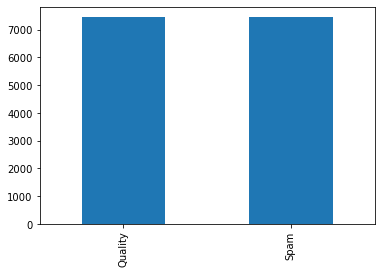

In [3]:
spam_count = len(train_df.loc[train_df['Type'] == 'Spam'])
non_spam_count = len(train_df.loc[train_df['Type'] == 'Quality'])
total = spam_count + non_spam_count

print("Spam count: {} ({:.2f}%)".format(spam_count, spam_count/total*100))
print("Quality count: {} ({:.2f}%)".format(non_spam_count, spam_count/total*100))

#remove south dakota label
train_df = train_df.loc[train_df['Type'] != 'South Dakota']
train_df.reset_index()

train_df['Type'].value_counts().plot(kind='bar')

In [4]:
#set the float print format
pd.set_option('float_format', '{:.4f}'.format)
train_df.describe()

,following,followers,actions,is_retweet
count,14739.0000,14880.0000,11461.0000,14896.0000
mean,4695.4300,353490.5045,6992.5234,0.2498
std,31898.3437,3890712.0545,15804.4514,0.4329
min,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,13.0000,0.0000
50%,74.0000,803.0000,1496.0000,0.0000
75%,3023.0000,13049.2500,6693.0000,0.0000
max,1600000.0000,105000000.0000,165599.0000,1.0000


In [5]:
#count nans 
print("NANs train_df")
print('===================')
print(train_df.isna().sum())

import numpy as np 

#replace NANs with median
train_df['following'].fillna(train_df['following'].median(), inplace=True)
train_df['followers'].fillna(train_df['followers'].median(), inplace=True)
train_df['actions'].fillna(  train_df['actions'].median(), inplace=True)
train_df['is_retweet'].fillna(0, inplace=True)

print('-------------------')
print(train_df.isna().sum())


#count nans 
# print('\n===================')
# print("NANs test_df")
# print('===================')
# print(test_df.isna().sum())

#replace NANs with median
test_df['following'].fillna(test_df['following'].median(), inplace=True)
test_df['followers'].fillna(test_df['followers'].median(), inplace=True)
test_df['actions'].fillna(  test_df['actions'].median(), inplace=True)

# print('-------------------')
# print(test_df.isna().sum())

NANs train_df
Tweet            0
following      158
followers       17
actions       3436
is_retweet       1
Type             0
dtype: int64
-------------------
Tweet         0
following     0
followers     0
actions       0
is_retweet    0
Type          0
dtype: int64


## Extração de Características
---

Extrair caracteristicas:  

*   Palavras: 
  *   Número de palavras [OK]
  *   Razão de # por total de palavras [OK] 
  *   Número de palavras da lista de palavras de spam  
  *   Razao URL por palavras [OK]

* Caracteres Númericos: 
  *   Número de caracteres numericos [OK]
  *   Numero de caracteres que sao numeros [WTF?]

* URLs: 
  *   Número de urlS [OK]

* Tweet:
  *   Número de mencoes [OK]
  *   Numero de #s [OK]
  *   Quantas vezes foi retweetado [VAI DA NAO]
  *   Tweet postado com reply  [VAI DA NAO]



In [25]:
import re
def find_url(string):
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url = re.findall(regex, string)      

    return url 

def has_url(string):
    return len(find_url(string)) > 0
   
def count_url(string):
    return len(find_url(string))

def count_words(string):
    words = string.split(' ')  

    return len(words)

def find_hashtag(string):
    regex = r"\B(\#[a-zA-Z]+\b)"
    hashtags = re.findall(regex, string)
  
    return hashtags

def count_hashtags(string: str):
    return len(find_hashtag(string))

def hashtag_per_word_ratio(string: str):
    hashtags_num = count_hashtags(string)
    words_num = count_words(string)

    return hashtags_num / words_num

def URL_per_word_ratio(string):
    urls_num = count_url(string)
    word_num = count_words(string)

    return urls_num / word_num

def count_numbers(string):
    #can't find decimal numbers 
    regex = "[0-9]+"
    numbers = re.findall(regex, string)
  
    return len(numbers)
  
def count_mentions(string):
    regex = r"(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9_]+)"
    mentions = re.findall(regex, string)

    return len(mentions)

#test find_url
string_test = 'me acha aqui https://dwefe.co eu tb porfaaa t.co/ddhdhy xuu :D'
print('URLs should be [https://dwefe.co, t.co/ddhdhy], find_url give: {}'.format([''.join(i) for i in find_url(string_test)]))

#test count_words
string_test = 'Olá eu sou uma string, com varias palavras foda. Mico-leao-dourado. E esse regex hein... Bem loco'
print('Count should be 16, count give: {}'.format(count_words(string_test)))

#test find_hashtags
string_test = 'Olá eu sou uma #hashtag, com #hashtag varias #palavrasFoda. #Mico-leao-dourado. #EEss<13e #regex #hashtagTeste regex hein... Bem loco'
print('Count should be 7, count give: {}'.format(count_hashtags(string_test)))

string_test = "Olá eu sou um4 str1n6 c0m v4ri0s num3r0s 123 2,2 #10"
print("Count should be 15 or 11 it was: ", count_numbers(string_test))

string_test = "Olar @fulano eu sou uma @stringdeTeste por@favor @meTesta umemail@gmail.com www.url@estr@nh@!"
print("Count should be 3 it was: ", count_mentions(string_test))

URLs should be [https://dwefe.co, t.co/ddhdhy], find_url give: ['https://dwefe.co', 't.co/ddhdhy']
Count should be 16, count give: 16
Count should be 7, count give: 7
Count should be 15 or 11 it was:  12
Count should be 3 it was:  3


In [7]:
train_df['words'] = train_df['Tweet'].apply(count_words)
train_df['hashtags'] = train_df['Tweet'].apply(count_hashtags)
train_df['hashtag_ratio'] = train_df['Tweet'].apply(hashtag_per_word_ratio)

train_df['URLs'] = train_df['Tweet'].apply(count_url)
train_df['URL_ratio'] = train_df['Tweet'].apply(URL_per_word_ratio)

train_df['numbers'] = train_df['Tweet'].apply(count_numbers)
train_df['mentions'] = train_df['Tweet'].apply(count_mentions)

new_columns = ['Tweet', 'following', 'followers', 'actions', 'is_retweet',
       'words', 'hashtags', 'hashtag_ratio', 'URLs', 'URL_ratio',
       'numbers', 'mentions', 'Type']

#new_columns = ['Tweet', 'following', 'followers', 'actions', 'is_retweet',
#       'words', 'hashtags', 'URLs',
#       'numbers', 'mentions', 'Type']

#reorder the columns
train_df = train_df[new_columns]
train_df.head()

,Tweet,following,followers,actions,is_retweet,words,hashtags,hashtag_ratio,URLs,URL_ratio,numbers,mentions,Type
0,Good Morning Love @LeeBrown_V,0.0000,0.0000,0.0000,0.0000,5,0,0.0000,0,0.0000,0,1,Quality
1,'@realDonaldTrump @USNavy RIP TO HEROES',42096.0000,61060.0000,5001.0000,0.0000,5,0,0.0000,0,0.0000,0,2,Spam
2,Haven't been following the news but I understa...,0.0000,0.0000,1496.0000,0.0000,14,1,0.0714,0,0.0000,0,0,Quality
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0000,0.0000,0.0000,0.0000,12,2,0.1667,2,0.1667,2,0,Quality
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,17800.0000,35100.0000,1496.0000,0.0000,17,2,0.1176,0,0.0000,2,1,Quality


In [8]:
test_df['words'] = test_df['Tweet'].apply(count_words)
test_df['hashtags'] = test_df['Tweet'].apply(count_hashtags)
test_df['hashtag_ratio'] = test_df['Tweet'].apply(hashtag_per_word_ratio)

test_df['URLs'] = test_df['Tweet'].apply(count_url)
test_df['URL_ratio'] = test_df['Tweet'].apply(URL_per_word_ratio)

test_df['numbers'] = test_df['Tweet'].apply(count_numbers)
test_df['mentions'] = test_df['Tweet'].apply(count_mentions)

test_df.head()

,Tweet,following,followers,actions,is_retweet,words,hashtags,hashtag_ratio,URLs,URL_ratio,numbers,mentions
0,"Cops shoot blacks almost everyday, and there a...",5509.0000,5977.0000,8062.0000,1,18,2,0.1111,0,0.0000,0,0
1,"#HAPPYTAEYANGDAY Oppa,happy birthday to you, ...",0.0000,0.0000,1638.0000,0,7,1,0.1429,1,0.1429,1,0
2,RT @HoneyBadger10: Panthers in the super bowl....,471.0000,229.0000,747.0000,0,11,1,0.0909,0,0.0000,1,1
3,Sorry my Twitter keeps posting my retweets a m...,0.0000,79800.0000,48.0000,0,10,0,0.0000,0,0.0000,0,0
4,Heart attack causes and symptoms are different...,902.0000,5797.0000,4270.0000,0,11,1,0.0909,0,0.0000,0,0


## Salvando dataset limpo

In [9]:
#save datasets
train_df.to_csv('model/dataset/train-tweets-clean.csv', sep = ',', header=True, index=False)
test_df.to_csv('model/dataset/test-tweets-clean.csv', sep = ',', header=True, index=False)

## Analise de URLs nos tweets 

- Porcentagem de tweets com urls divididos por classe 
- Relação entre tamanho do tweet e tamanho do url 

Spams that have URLs
True    0.6119
False   0.3881
Name: Tweet, dtype: float64

Non-spam that have URLs
True    0.5237
False   0.4763
Name: Tweet, dtype: float64
Count tweet that have URLs


,spam counts,spam %,non-spam counts,non-spam %
0,2889.0000,38.8150,3550,47.6254
1,2973.0000,39.9436,3288,44.1105
2,1525.0000,20.4891,593,7.9555
3,56.0000,0.7524,17,0.2281
4,NaN,NaN,5,0.0671
5,NaN,NaN,1,0.0134


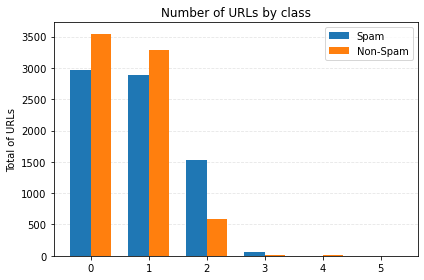

In [10]:
#filter by class 
spam = train_df.loc[train_df['Type'] == 'Spam']
non_spam = train_df.loc[train_df['Type'] == 'Quality']

#how many tweets have urls per class
spam_urls     = spam['Tweet'].apply(has_url)
non_spam_urls = non_spam['Tweet'].apply(has_url)

print('Spams that have URLs')
print(spam_urls.value_counts(normalize = True))

print('\nNon-spam that have URLs')
print(non_spam_urls.value_counts(normalize = True))


print('Count tweet that have URLs')
spam_urls = pd.concat([spam['URLs'].value_counts(),
                       spam['URLs'].value_counts(normalize = True).mul(100), 
                       non_spam['URLs'].value_counts(), 
                       non_spam['URLs'].value_counts(normalize = True).mul(100)], 
                       axis = 1, keys = ('spam counts', 'spam %', 'non-spam counts', 'non-spam %'))
display(spam_urls)

#spam_urls = spam
#quality_urls = non_spam

# URL_count_spam = pd.concat([spam['URLs'].value_counts(),
#                             spam['URLs'].value_counts(normalize = True).mul(100)], 
#                             axis=1, keys = ('counts', 'percentage'))

# URL_count_quality = pd.concat([non_spam['URLs'].value_counts(),
#                                non_spam['URLs'].value_counts(normalize = True).mul(100)],
#                               axis=1, keys = ('counts', 'percentage'))

# print(URL_count_spam)
# print(URL_count_quality)

URL_count_spam = spam['URLs'].value_counts().to_list()
URL_count_quality = non_spam['URLs'].value_counts().to_list()

while(len(URL_count_quality) > len(URL_count_spam)):
    URL_count_spam.append(0)

import matplotlib.pyplot as plt

labels = ['0', '1', '2', '3', '4', '5']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, URL_count_spam, width, label='Spam')
rects2 = ax.bar(x + width/2, URL_count_quality, width, label='Non-Spam')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total of URLs')
ax.set_title('Number of URLs by class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.2)

fig.tight_layout()

plt.show()


## Análise de Hashtags

In [11]:
print('Count hashtags')

count_hashtags = pd.concat([spam['hashtags'].value_counts(),
                       spam['hashtags'].value_counts(normalize = True).mul(100), 
                       non_spam['hashtags'].value_counts(), 
                       non_spam['hashtags'].value_counts(normalize = True).mul(100)], 
                       axis = 1, keys = ('spam', 'spam %', 'non-spam', 'non-spam %'))
display(count_hashtags)

Count hashtags


,spam,spam %,non-spam,non-spam %
0,3855,51.7936,5849.0000,78.4679
1,2638,35.4427,984.0000,13.2010
2,691,9.2839,360.0000,4.8296
3,137,1.8407,137.0000,1.8379
4,57,0.7658,67.0000,0.8988
5,31,0.4165,34.0000,0.4561
6,13,0.1747,17.0000,0.2281
7,5,0.0672,1.0000,0.0134
8,8,0.1075,3.0000,0.0402
9,3,0.0403,2.0000,0.0268


## Machine Learning ✋⚡🧠

### Abrindo base limpa

In [12]:
import pandas as pd

df = pd.read_csv('model/dataset/train-tweets-clean.csv', delimiter = ',')
df

,Tweet,following,followers,actions,is_retweet,words,hashtags,hashtag_ratio,URLs,URL_ratio,numbers,mentions,Type
0,Good Morning Love @LeeBrown_V,0.0000,0.0000,0.0000,0.0000,5,0,0.0000,0,0.0000,0,1,Quality
1,'@realDonaldTrump @USNavy RIP TO HEROES',42096.0000,61060.0000,5001.0000,0.0000,5,0,0.0000,0,0.0000,0,2,Spam
2,Haven't been following the news but I understa...,0.0000,0.0000,1496.0000,0.0000,14,1,0.0714,0,0.0000,0,0,Quality
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0000,0.0000,0.0000,0.0000,12,2,0.1667,2,0.1667,2,0,Quality
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,17800.0000,35100.0000,1496.0000,0.0000,17,2,0.1176,0,0.0000,2,1,Quality
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14892,"#AllWentWrongWhen I told my hair stylist to ""g...",695.0000,533.0000,868.0000,1.0000,9,1,0.1111,0,0.0000,0,0,Spam
14893,"They don't have to like you, and you don't hav...",0.0000,0.0000,0.0000,0.0000,12,0,0.0000,0,0.0000,0,0,Quality
14894,#Miami Graham Nash Live at Parker Playhouse #...,5647.0000,15091.0000,5823.0000,0.0000,9,2,0.2222,0,0.0000,0,0,Spam
14895,@bethannhamilton is in the business of one-upp...,0.0000,0.0000,1496.0000,0.0000,15,0,0.0000,0,0.0000,0,1,Quality


### Sobre o is_retweet
#### Existem duas opções de retweet. A primeira é uma cópia exata do tweet e a segunda vc faz um comentário desse tweet e o tweet original vai como um link. Por isso alguns tweets que o campo is_retweet está como True pode ou não ter uma url levando a um outro tweet.

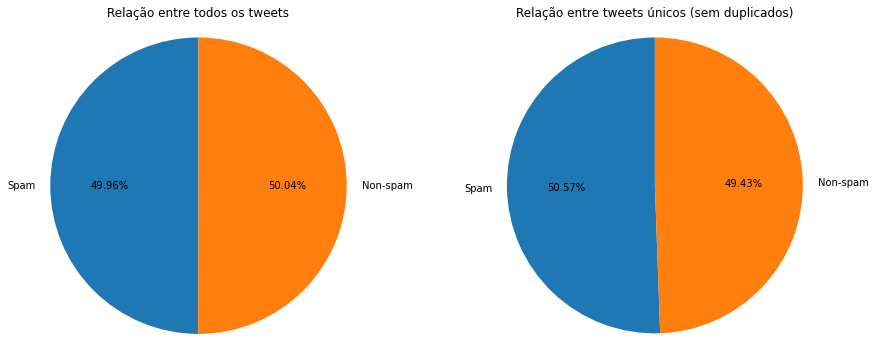

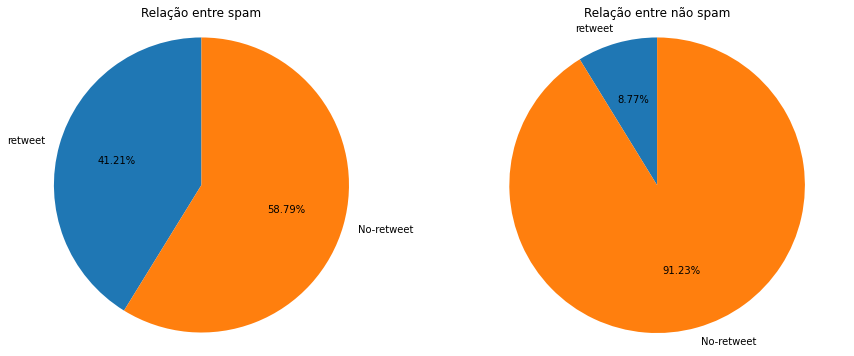

In [30]:
def pie_chart_tweets(df1, df2, column, comp1, comp2, labels, description):
    spam = len(df1[df1[column] == comp1])
    non_spam = len(df1[df1[column] == comp2])
    all_sizes = [spam/len(df1), non_spam/len(df1)]
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    axes[0].set_title(description[0])
    axes[0].pie(all_sizes, labels=labels, autopct='%1.2f%%', startangle=90)
    axes[0].axis('equal')
    
    spam = len(df2[df2[column] == comp1])
    non_spam = len(df2[df2[column] == comp2])
    unique_sizes = [spam/len(df2), non_spam/len(df2)]

    axes[1].set_title(description[1])
    axes[1].pie(unique_sizes, labels=labels, autopct='%1.2f%%', startangle=90)
    axes[1].axis('equal')

    plt.show()

labels = 'Spam', 'Non-spam'
description = ["Relação entre todos os tweets", "Relação entre tweets únicos (sem duplicados)"]
df_unique = df.drop_duplicates(subset="Tweet")
pie_chart_tweets(df, df_unique, "Type", "Spam", "Quality", labels, description)

labels = 'retweet', 'No-retweet'
description = ["Relação entre spam", "Relação entre não spam"]
pie_chart_tweets(df[df["Type"] == "Spam"], df[df["Type"] == "Quality"], "is_retweet", 1, 0, labels, description)

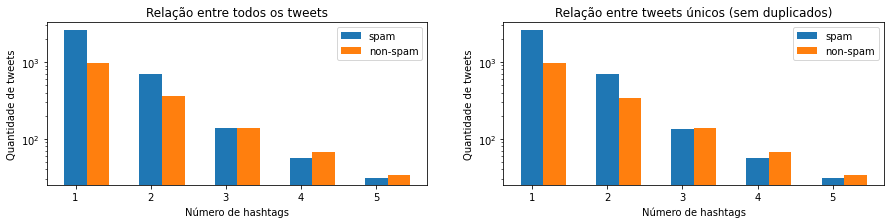

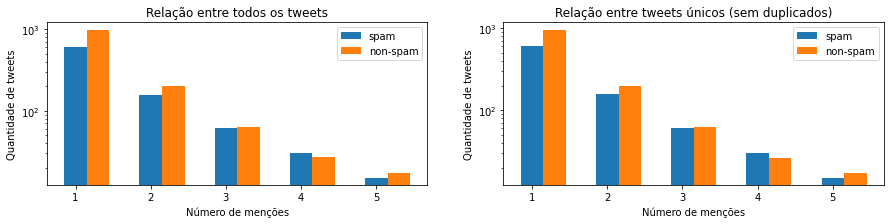

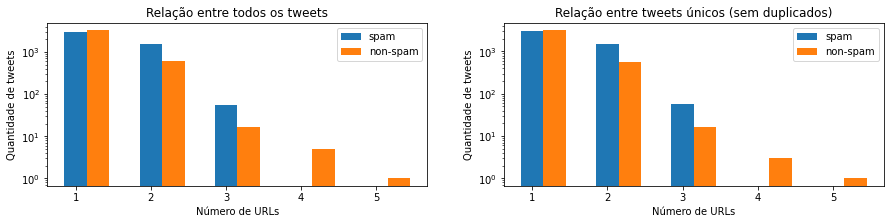

In [31]:
def count_col(df, num):
    tweets = {
        "Spam": [],
        "Quality": []
    }
    for tp, l in tweets.items():
        all_tweets = df[df['Type'] == tp]
        for i in limit:
            count_values = len(all_tweets[all_tweets[num] == i])
            l.append(count_values)
    
    return tweets

def get_col_counts_plot(df, limit, num, description):
    list_test = []
    list2_test = []

    all_tweets = count_col(df, num)
    unique_tweets = count_col(df.drop_duplicates(subset="Tweet"), num)
    
    width = 0.3
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
    
    #For all tweets
    #print(f"ALL spam tweets: {all_tweets['Spam']}")
    #print(f"ALL Quality tweets: {all_tweets['Quality']}")
    axes[0].bar(limit, all_tweets["Spam"], width, label = "spam")
    axes[0].bar(limit + width, all_tweets["Quality"], width, label = "non-spam")

    axes[0].set_title("Relação entre todos os tweets")
    axes[0].set_yscale('log')
    axes[0].legend()
    axes[0].set_xlabel(description)
    axes[0].set_ylabel('Quantidade de tweets')
    axes[0].set_xticks(limit)
    
    #For unique tweets
    #print(f"UNIQUE spam tweets: {unique_tweets['Spam']}")
    #print(f"UNIQUE Quality tweets: {unique_tweets['Quality']}")
    axes[1].bar(limit, unique_tweets["Spam"], width, label = "spam")
    axes[1].bar(limit + width, unique_tweets["Quality"], width, label = "non-spam")
    
    axes[1].set_title("Relação entre tweets únicos (sem duplicados)")
    axes[1].set_yscale('log')
    axes[1].legend()
    axes[1].set_xlabel(description)
    axes[1].set_ylabel('Quantidade de tweets')
    axes[1].set_xticks(limit)

    plt.show()
    #print("-"*20)

#grafico do teste followers/following
limit = np.arange(1, 6, 1)
get_col_counts_plot(df, limit, 'hashtags', "Número de hashtags")
limit = np.arange(1, 6, 1)
get_col_counts_plot(df, limit, 'mentions', "Número de menções")
limit = np.arange(1, 6, 1)
get_col_counts_plot(df, limit, 'URLs', "Número de URLs")

In [32]:
import os

def clean_url(i):
    """
        Some URLs have concatenated strings in it. The only one easy to 'clean', is the https://t.co/...
    """

    return i[:23]

def get_all_infos(df, tp, func):
    info = df[df["Type"] == tp]
    
    all_infos = {}
    for tweet in info["Tweet"]:
        infos = []
        try:
            infos = [''.join(i) for i in func(tweet)]
        except Exception as ex:
            pass
        else:
            for i in infos:
                if "https://t.co/" in i:
                    i = clean_url(i)
                if i in all_infos:
                    all_infos[i] += 1
                else:
                    all_infos[i] = 1

    return all_infos

def get_ranking(rank_dict, rank, columns):
    rank_dict = dict(sorted(rank_dict.items(), key=lambda x: x[1], reverse=True))
    
    keys = []
    values = []
    for i, v in enumerate(rank_dict):
        if i == 5:
            break

        value = rank_dict[v]
        if columns[0] == "URLs":
            #se for url, acha a url normal (a maioria do twitter vem na forma t.co)
            v = os.popen(
                f"curl -s -o /dev/null --head -w '%{{url_effective}}\n' -L {v}").read()
            v = v.split('\n')[0]
        keys.append(v)
        values.append(value)
    
    return pd.DataFrame(list(zip(keys, values)), index=np.arange(1, rank+1, 1), columns=columns)

spam_hashtags = get_all_infos(df, "Spam", find_hashtag)
quality_hashtags = get_all_infos(df, "Quality", find_hashtag)

top_spam = get_ranking(spam_hashtags, 5, ["Hashtags", "Quantidade"])
top_quality = get_ranking(quality_hashtags, 5, ["Hashtags", "Quantidade"])

print("Top 5 Hashtags in spam and non-spam tweets")
pd.concat([d.reset_index(drop=True) for d in [top_spam, top_quality]], axis=1)

Top 5 Hashtags in spam and non-spam tweets


,Hashtags,Quantidade,Hashtags,Quantidade
0,#news,475,#HAPPYBAEBAEDAYpic,21
1,#sports,196,#HAPPYTAEYANGDAY,17
2,#politics,150,#WhyMediaHidesFacts,11
3,#local,100,#aqabiology,11
4,#world,97,#ALDUBLoversInITALYpic,10


In [33]:
spam_urls = get_all_infos(df, "Spam", find_url)
quality_urls = get_all_infos(df, "Quality", find_url)

top_spam = get_ranking(spam_urls, 5, ["URLs", "Quantidade"])
top_quality = get_ranking(quality_urls, 5, ["URLs", "Quantidade"])

print("Top 5 URLs in spam and non-spam tweets")
pd.concat([d.reset_index(drop=True) for d in [top_spam, top_quality]], axis=1)

Top 5 URLs in spam and non-spam tweets


,URLs,Quantidade,URLs,Quantidade
0,https://1063.mobi/,12,https://yg-life.com/?lang=ko,12
1,https://twibble.io/,8,http://HAPPYBAEBAEDAYpic.twitter.com/Lib0qxwsyr,12
2,https://twibble.io/,8,http://mpic.twitter.com/C9lC69C4WD,8
3,https://covfefe.bz/,7,https://twitter.com/skynews/status/73256156416...,7
4,https://twibble.io/,5,http://www.gomplaces.com/,7


In [34]:
def get_data_info(data_df, tweet_type):
    #todos os tweets do tipo 'tweet_type'
    only_tweet_type = data_df[data_df['Type'] == tweet_type]
    
    #tweets que possuem urls
    tweet_url = only_tweet_type[only_tweet_type['URLs'] > 0]
    #tweets que possuem mais de 1 urls
    more_one_url = only_tweet_type[only_tweet_type['URLs'] > 1]
    
    #quantidade de tweets do tipo 'tweet_type'
    tweet_count = len(only_tweet_type)

    #quantidade de tweets com url
    tweet_url_count = len(tweet_url)
    #quantidade de tweets com mais de uma url
    tweet_more_one_url_count = len(more_one_url)
    
    #tweets unicos (sem repetição)
    unique_tweet = only_tweet_type['Tweet'].unique()
    #quantidade de tweets unicos (sem repetição)
    unique_tweet_count = len(unique_tweet)
    
    return [
        f"{tweet_count} ({(tweet_count/len(data_df))*100:.2f}%)",
        unique_tweet_count,
        f"{(unique_tweet_count/tweet_count)*100:.2f}%",
        tweet_url_count,
        f"{(tweet_url_count/tweet_count)*100:.2f}%",
        tweet_more_one_url_count,
        f"{(tweet_more_one_url_count/tweet_url_count)*100:.2f}%"
    ]

def create_info_table(df):
    spam = get_data_info(df, "Spam")
    non_spam = get_data_info(df, "Quality")

    index = [
        "Tweets identificados",
        "Tweets únicos (sem repetição)",
        "Tweets únicos/identificados",
        "Total de urls",
        "urls/identificados",
        "mais de 1 url", 
        "mais de 1 url/total de urls"
    ]
    return pd.DataFrame(list(zip(spam, non_spam)), index=index, columns=["spam", "non-spam"])
    
result_df = create_info_table(df)
result_df

,spam,non-spam
Tweets identificados,7443 (49.96%),7454 (50.04%)
Tweets únicos (sem repetição),7424,7256
Tweets únicos/identificados,99.74%,97.34%
Total de urls,4554,3904
urls/identificados,61.19%,52.37%
mais de 1 url,1581,616
mais de 1 url/total de urls,34.72%,15.78%


### Preparação dos Dados

- Remove coluna tweet
- Separa coluna types para ser label
- Converte label string para numerica

In [20]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np 

n_columns = len(df.columns)

#filter data to that will be used by the model
X = df.iloc[:, 1: n_columns - 1] 
y = df['Type']

#convert to numpy array 
X = X.to_numpy()
y = y.to_numpy()

#binarize the labels
#Quality -> 0 
#Spam -> 1
lb = LabelBinarizer()
y = lb.fit_transform(y)

### Train test split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 13)

print('Len train: {} - {:.2f}%'.format(len(y_train), len(y_train)/ len(y)*100))
print('Len test:  {} - {:.2f}%'.format(len(y_test), len(y_test)/ len(y)*100))

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test  = np.unique(y_test, return_counts=True)

train_count = dict(zip(unique_train, counts_train))
test_count = dict(zip(unique_test, counts_test))

print('Train count: ', train_count)
print('Test count: ', test_count)

Len train: 11917 - 80.00%
Len test:  2980 - 20.00%
Train count:  {0: 5929, 1: 5988}
Test count:  {0: 1525, 1: 1455}


### Normalização 

In [22]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)

### GridSearch

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, roc_curve, precision_recall_curve, auc, make_scorer, classification_report,  recall_score, accuracy_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np 
np.random.seed(10)

In [17]:
def apply_grid_search(X_train, y_train, X_test, y_test, clf, param_grid):
  
    scorers = {
      'precision_score': make_scorer(precision_score),
      'recall_score': make_scorer(recall_score),
      'accuracy_score': make_scorer(accuracy_score)
    }

    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit='precision_score', return_train_score= True, n_jobs=-1)
    grid_search.fit(X_train, y_train.ravel())

    y_pred = grid_search.predict(X_test)

    print(grid_search.best_params_)
    print(confusion_matrix(y_pred, y_test))

    return grid_search, grid_search.best_params_

### Random Forest

In [32]:
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 6, 11]
}

  
best_clf, best_param = apply_grid_search(X_train, y_train, X_test, y_test, clf, param_grid)
print(best_param)

{'max_depth': 25, 'max_features': 3, 'min_samples_split': 10, 'n_estimators': 100}
[[1521   12]
 [   4 1443]]
{'max_depth': 25, 'max_features': 3, 'min_samples_split': 10, 'n_estimators': 100}


### KNN

In [33]:
knn_params = {
    'n_neighbors': [3, 5, 7, 10], 
    'algorithm' : ['auto', 'ball_tree', 'kd_tree'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
knn, best_knn_param = apply_grid_search(X_train, y_train, X_test, y_test, knn, knn_params)

print(best_knn_param)

{'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 10}
[[1341  267]
 [ 184 1188]]
{'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 10}


### MLP

In [34]:
mlp_params = {
    'hidden_layer_sizes' : [80, 100, 130],
    'learning_rate_init' : [0.001, 0.0001],
    'max_iter' : [100, 150, 200]
}

mlp = MLPClassifier(early_stopping=True)
mlp, best_mlp_param = apply_grid_search(X_train, y_train, X_test, y_test, mlp, mlp_params)

{'hidden_layer_sizes': 80, 'learning_rate_init': 0.001, 'max_iter': 200}
[[1369  165]
 [ 156 1290]]


### Treinamento K-fold

In [48]:
from sklearn.model_selection import StratifiedKFold
import numpy as np 
import copy

def percent(a, b):
    return (a / b) * 100  

def calculate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cf = confusion_matrix(y_true, y_pred)

    metrics = {'Acuracia': acc, 'Precisao': precision, 'Recall': recall, 'F1Score': f1, 'ConfusionMatrix' : cf}
  
    return metrics 

np.random.seed(10)
K_FOLDS = 5
 
#prepare classifiers
classifiers = {'RandomForest': RandomForestClassifier(n_estimators=100, max_depth = 15, max_features = 3 , min_samples_split = 3, random_state = 13), 
               'KNN': KNeighborsClassifier(n_neighbors = 10, algorithm='auto', metric = 'manhattan'),
               'MLP' : MLPClassifier(hidden_layer_sizes = 80, learning_rate_init = 0.001, max_iter= 150, early_stopping=True, random_state = 13)}

metrics = {'RandomForest': {'train': {}, 'test': {}},
           'KNN' : {'train': {}, 'test': {}},
           'MLP' : {'train': {}, 'test': {}}
           }

roc_curve_metrics = {'RandomForest' : {'FP': 0.0, 'TP': 0.0, 'Threshold': 0.0},
             'KNN' : {'FP': 0.0, 'TP': 0.0, 'Threshold': 0.0},
             'MLP' : {'FP': 0.0, 'TP': 0.0, 'Threshold': 0.0}
            }

#store the classifiers dict for every fold
fold_classifiers = []
fold_metrics = []
roc_curves = [] 

skfold = StratifiedKFold(n_splits = K_FOLDS)
skfold.get_n_splits(X, y)
fold_count = 0

for train_index, test_index in skfold.split(X, y):
    print('------------------------------------------')
    print('Fold {} out of 5'.format(fold_count + 1))
    len_train, len_test = len(train_index), len(test_index)
    total = len_train + len_test

    print('Train: {} {:.2f}% Test: {} {:.2f}%'.format(len_train, percent(len_train, total), len_test, percent(len_test, total)))
  
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
  

    for clf_name, classifier in classifiers.items():
        print('Training {}...'.format(clf_name))
        classifier.fit(X_train, y_train.ravel())

        y_pred_train = classifier.predict(X_train)
        y_pred_test = classifier.predict(X_test)
    
        metrics[clf_name]['train'] = copy.deepcopy(calculate_metrics(y_train, y_pred_train))
        metrics[clf_name]['test'] = copy.deepcopy(calculate_metrics(y_test, y_pred_test))
    
        #calculate roc_curves
        y_pred_test_prob = classifier.predict_proba(X_test)[:, 1]
    
        fpr, tpr, thr = roc_curve(y_test.ravel(), y_pred_test_prob)
    
        roc_curve_metrics[clf_name]['FP'] = copy.deepcopy(fpr)
        roc_curve_metrics[clf_name]['TP'] = copy.deepcopy(tpr)
        roc_curve_metrics[clf_name]['Threshold'] = copy.deepcopy(thr)

  
    fold_classifiers.append(classifiers)
    fold_metrics.append(copy.deepcopy(metrics))
    roc_curves.append(copy.deepcopy(roc_curve_metrics))

    fold_count = fold_count + 1

------------------------------------------
Fold 1 out of 5
Train: 11917 80.00% Test: 2980 20.00%
Training RandomForest...
Training KNN...
Training MLP...
------------------------------------------
Fold 2 out of 5
Train: 11917 80.00% Test: 2980 20.00%
Training RandomForest...
Training KNN...
Training MLP...
------------------------------------------
Fold 3 out of 5
Train: 11918 80.00% Test: 2979 20.00%
Training RandomForest...
Training KNN...
Training MLP...
------------------------------------------
Fold 4 out of 5
Train: 11918 80.00% Test: 2979 20.00%
Training RandomForest...
Training KNN...
Training MLP...
------------------------------------------
Fold 5 out of 5
Train: 11918 80.00% Test: 2979 20.00%
Training RandomForest...
Training KNN...
Training MLP...


### Avaliação K-folds

In [49]:
for fold in range(K_FOLDS):
    print('\n=========== Fold {} ===============\n'.format(fold))

    for clf_name in fold_classifiers[fold].keys():

        print('\n-- {} --'.format(clf_name))

        acc_train  = fold_metrics[fold][clf_name]['train']['Acuracia']
        prec_train = fold_metrics[fold][clf_name]['train']['Precisao']
        rec_train  = fold_metrics[fold][clf_name]['train']['Recall']
        f1_train   = fold_metrics[fold][clf_name]['train']['F1Score']
        cm_train   = fold_metrics[fold][clf_name]['test']['ConfusionMatrix']

        acc_test  = fold_metrics[fold][clf_name]['test']['Acuracia'] 
        prec_test = fold_metrics[fold][clf_name]['test']['Precisao'] 
        rec_test  = fold_metrics[fold][clf_name]['test']['Recall'] 
        f1_test   = fold_metrics[fold][clf_name]['test']['F1Score']
        cm_test   = fold_metrics[fold][clf_name]['test']['ConfusionMatrix']

        print('          Treino - Teste')
        print('Acuracia:  {:.2f}  -  {:.2f}'.format(acc_train, acc_test))
        print('Precisao:  {:.2f}  -  {:.2f}'.format(prec_train, prec_test))
        print('Recall:    {:.2f}  -  {:.2f}'.format(rec_train, rec_test))
        print('F1 Score:  {:.2f}  -  {:.2f}'.format(f1_train, f1_test))


=========== Fold 0 ===============


-- RandomForest --
          Treino - Teste
Acuracia:  1.00  -  1.00
Precisao:  1.00  -  1.00
Recall:    1.00  -  1.00
F1 Score:  1.00  -  1.00

-- KNN --
          Treino - Teste
Acuracia:  0.99  -  0.99
Precisao:  1.00  -  0.99
Recall:    0.98  -  0.98
F1 Score:  0.99  -  0.99

-- MLP --
          Treino - Teste
Acuracia:  0.98  -  0.99
Precisao:  0.99  -  0.99
Recall:    0.97  -  0.98
F1 Score:  0.98  -  0.99

=========== Fold 1 ===============


-- RandomForest --
          Treino - Teste
Acuracia:  1.00  -  1.00
Precisao:  1.00  -  1.00
Recall:    1.00  -  1.00
F1 Score:  1.00  -  1.00

-- KNN --
          Treino - Teste
Acuracia:  0.99  -  0.99
Precisao:  1.00  -  0.99
Recall:    0.98  -  0.98
F1 Score:  0.99  -  0.99

-- MLP --
          Treino - Teste
Acuracia:  0.98  -  0.98
Precisao:  0.99  -  0.99
Recall:    0.97  -  0.97
F1 Score:  0.98  -  0.98

=========== Fold 2 ===============


-- RandomForest --
          Treino - Teste
Acuracia: 

### Curva ROC

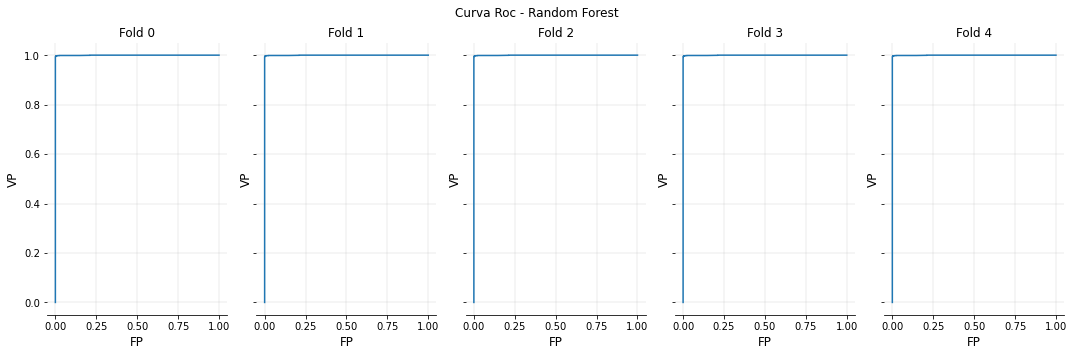

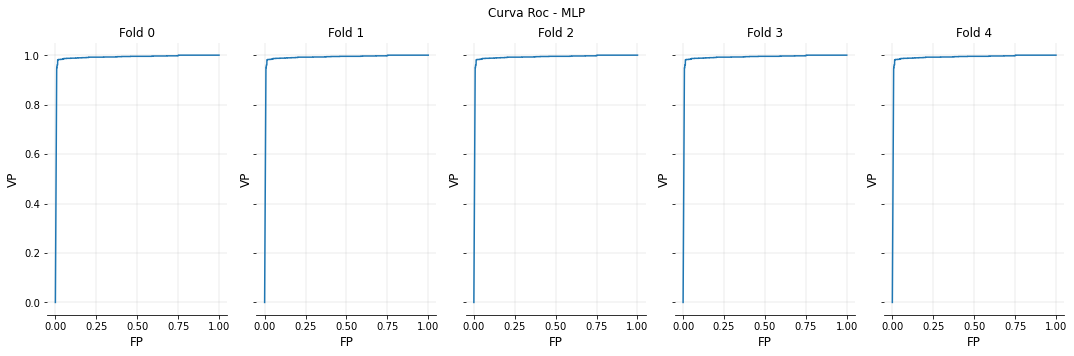

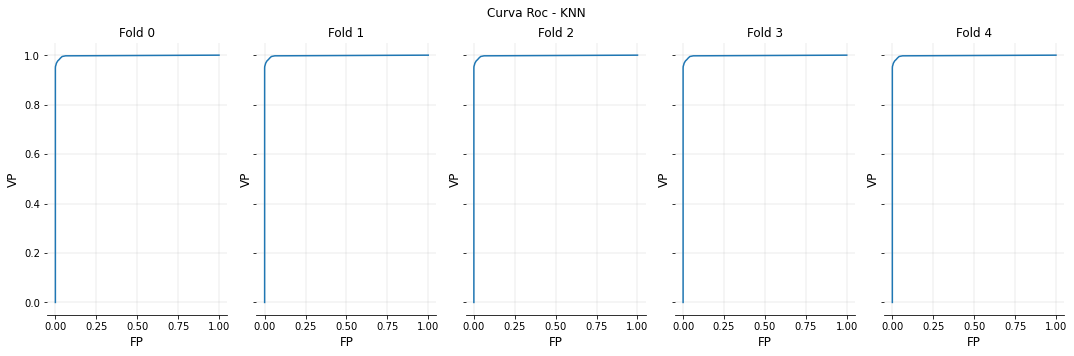

In [27]:
import matplotlib.pyplot as plt 

def plotRocCurveFolds(roc_dict, n_folds, sup_title, clf_name):

    fig, axs = plt.subplots(nrows=1, ncols=5, sharey=True, sharex=True, figsize=(15,5))

    for fold in range(5):
        axs[fold].plot(roc_dict[fold][clf_name]['FP'], roc_dict[fold][clf_name]['TP'])
        axs[fold].set_title('Fold ' + str(fold))
        axs[fold].set_xlabel('FP', fontsize=12)
        axs[fold].set_ylabel('VP', fontsize=12)

        axs[fold].grid(linewidth=0.25)

        #remove bounding box around the graphs 
        axs[fold].spines['left'].set_visible(False)
        axs[fold].spines['top'].set_visible(False)
        axs[fold].spines['right'].set_visible(False)  

    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    fig.suptitle(sup_title)
  
    return fig, axs 

fig, axs = plotRocCurveFolds(roc_dict = roc_curves, n_folds = 5, sup_title='Curva Roc - Random Forest' , clf_name='RandomForest')
plt.show()

fig, axs = plotRocCurveFolds(roc_dict = roc_curves, n_folds = 5, sup_title='Curva Roc - MLP' , clf_name='MLP')
plt.show()

fig, axs = plotRocCurveFolds(roc_dict = roc_curves, n_folds = 5, sup_title='Curva Roc - KNN' , clf_name='KNN')
plt.show()

In [67]:
import numpy as np
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

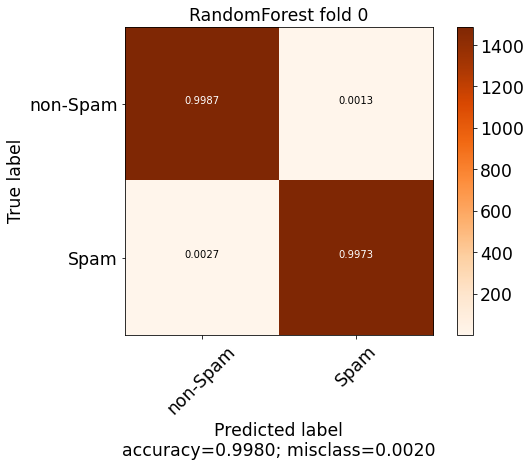

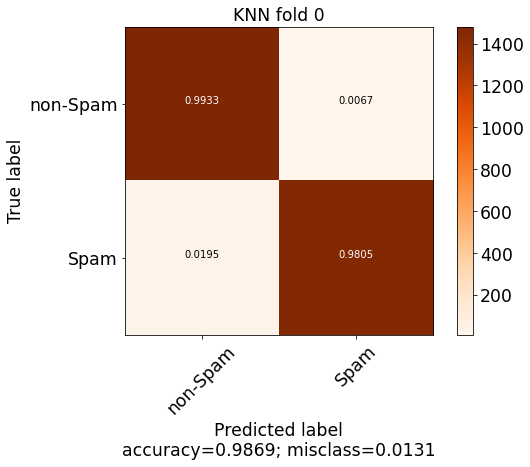

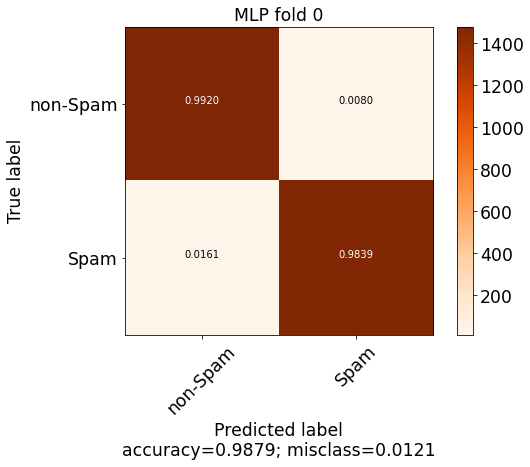

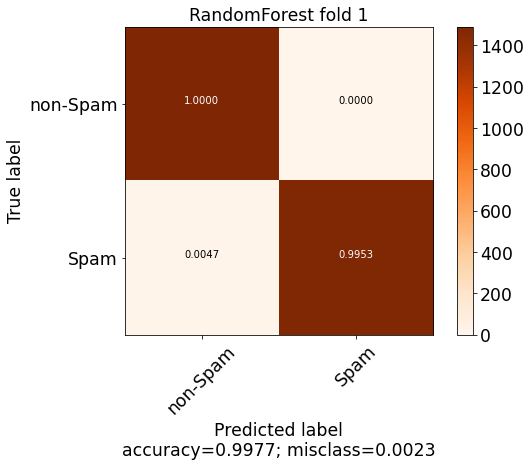

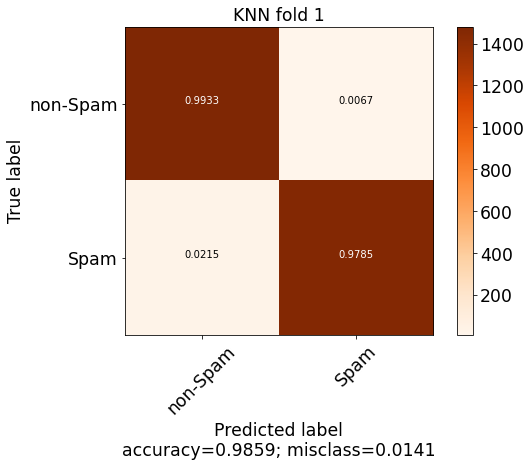

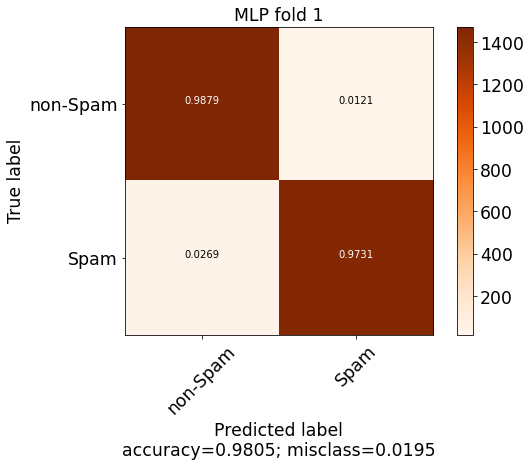

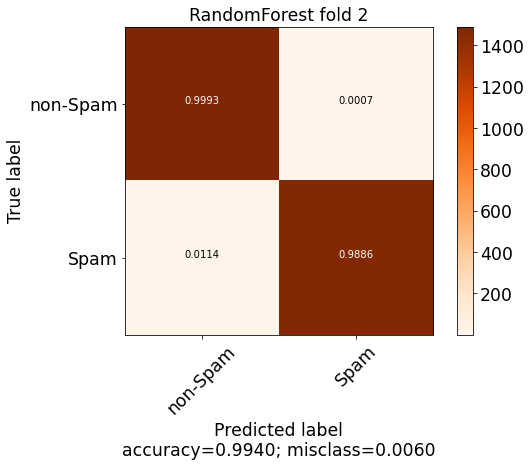

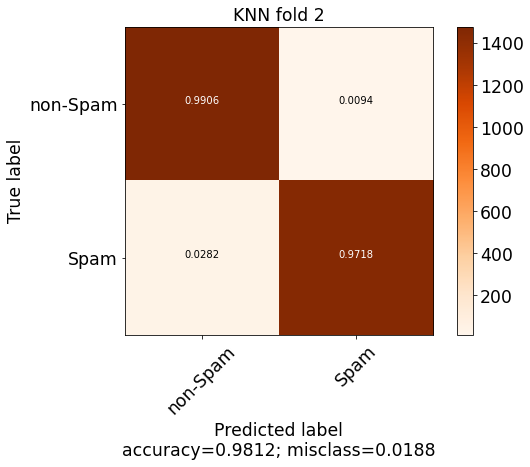

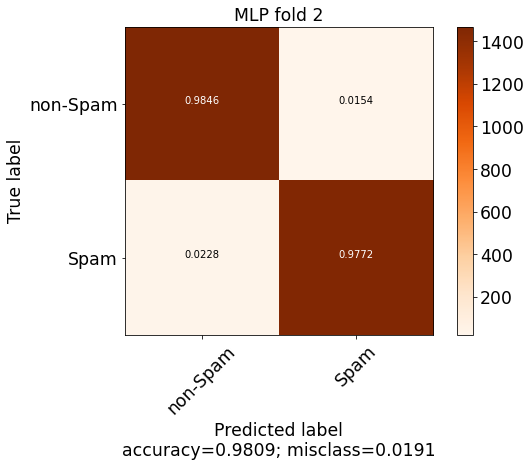

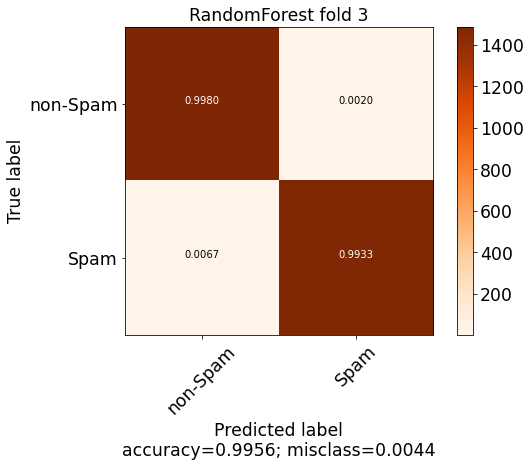

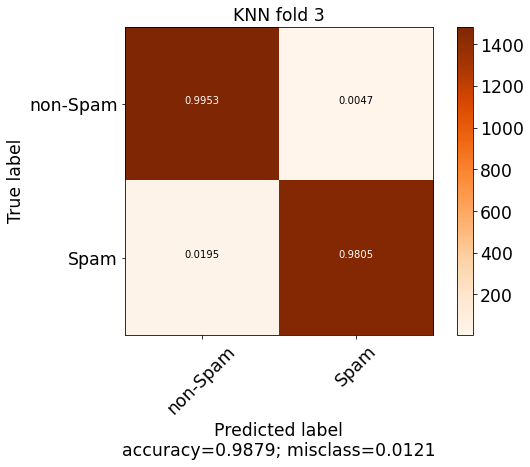

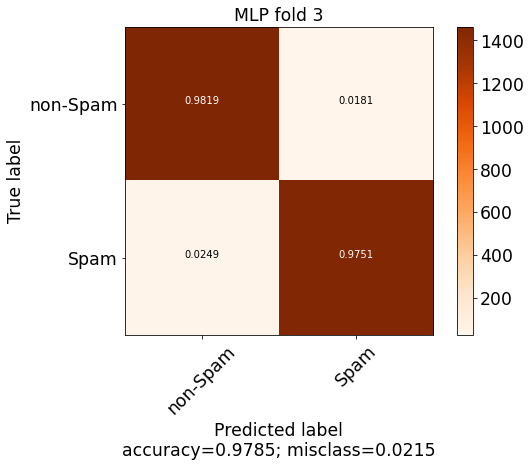

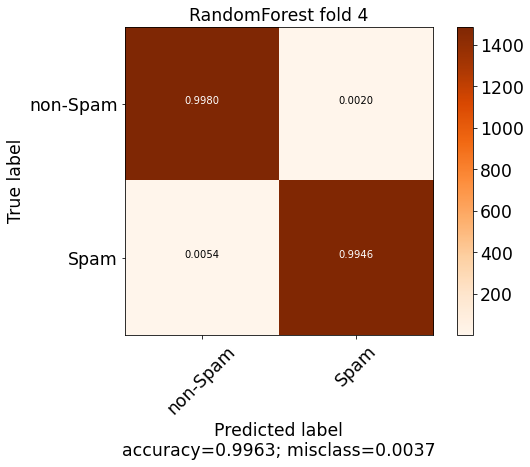

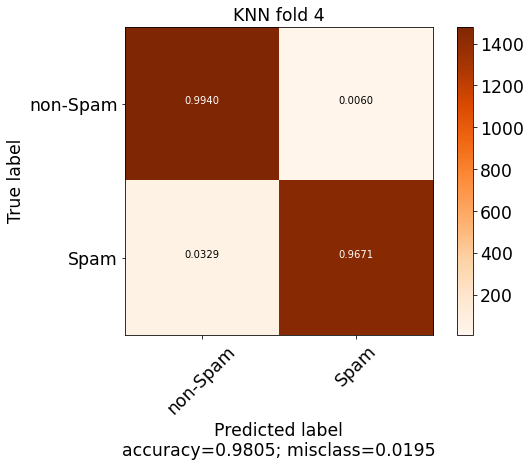

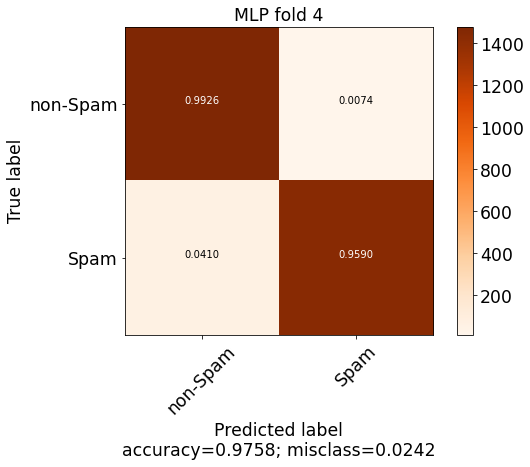

In [68]:
for fold in range(K_FOLDS): 
    for clf_name in fold_classifiers[fold].keys():
        plot_confusion_matrix(cm = fold_metrics[fold][clf_name]['test']['ConfusionMatrix'],
                         normalize    = True,
                         target_names = ['non-Spam', 'Spam'],       
                         title        = clf_name + ' fold ' + str(fold))

## Avaliando tweets selvagens


In [56]:
def feature_extraction(df):
    df['words'] = df['Tweet'].apply(count_words)
    df['hashtags'] = df['Tweet'].apply(count_hashtags)
    df['hashtag_ratio'] = df['Tweet'].apply(hashtag_per_word_ratio)

    df['URLs'] = df['Tweet'].apply(count_url)
    df['URL_ratio'] = df['Tweet'].apply(URL_per_word_ratio)

    df['numbers'] = df['Tweet'].apply(count_numbers)
    df['mentions'] = df['Tweet'].apply(count_mentions)

    new_columns = ['Tweet', 'following', 'followers', 'actions', 'is_retweet',
        'words', 'hashtags', 'hashtag_ratio', 'URLs', 'URL_ratio',
        'numbers', 'mentions']

    #reorder the columns
    df = df[new_columns]
  
    return df

type_dict = {'Tweet': str, 'following':int, 'followers':int, 'actions': int, 'is_retweet' : bool, 'tweet_url' : str}
bolso_df = pd.read_csv('tweets_selvagens/bolsonaro_file.csv', quotechar="'", dtype = type_dict, delimiter = ',', warn_bad_lines=True, error_bad_lines=False)
print(len(bolso_df.index))

bolso_df = feature_extraction(bolso_df)
bolso_df

/home/claudio/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/home/claudio/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 32: expected 7 fields, saw 10\nSkipping line 107: expected 7 fields, saw 8\nSkipping line 196: expected 7 fields, saw 9\nSkipping line 360: expected 7 fields, saw 9\nSkipping line 397: expected 7 fields, saw 8\nSkipping line 605: expected 7 fields, saw 9\nSkipping line 665: expected 7 fields, saw 9\nSkipping line 894: expected 7 fields, saw 8\nSkipping line 927: expected 7 fields, saw 8\nSkipping line 953: expected 7 fields, saw 8\nSkipping line 976: expected 7 fields, saw 8\nSkipping l

2482


,Tweet,following,followers,actions,is_retweet,words,hashtags,hashtag_ratio,URLs,URL_ratio,numbers,mentions
0,Primeira Dama Michele Bolsonaro agradecendo a ...,3165,5076,302,True,28,0,0.0000,1,0.0357,3,0
1,@pattisonbf parece os filhos do bolsonaro,107,529,0,False,6,0,0.0000,0,0.0000,0,1
2,@folha Quem tentou destruir a democracia foi o...,4,1,0,False,40,0,0.0000,0,0.0000,0,1
3,@TerraBrasilnot Acho q o imorais precisar ler ...,3975,6606,2,True,31,0,0.0000,0,0.0000,0,1
4,Rachadinha: suposto ex-funcionário de Carlos B...,2139,566,53,True,15,0,0.0000,1,0.0667,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2477,"Pela fase de grupos da UEFA Champions League, ...",6,28,0,False,26,0,0.0000,0,0.0000,5,0
2478,Lula é o maior ladrão de todos os tempos...#Lu...,357,471,7,True,10,1,0.1000,1,0.1000,3,0
2479,@pinto_saullo12 Se queremos derrotar Bolsonaro...,17783,16758,0,False,30,0,0.0000,1,0.0333,1,1
2480,@TradutordoBR Só observar os que odeiam BOLSON...,206,107,0,False,10,0,0.0000,0,0.0000,1,1


In [57]:
bolso_df_copy = bolso_df.copy()
bolso_df_2 = bolso_df_copy.iloc[:, 1:]

bolso_df_2["is_retweet"].replace({True:1, False:0}, inplace=True)

#min_max_scaler = MinMaxScaler()
#bolso_df_2 = min_max_scaler.fit_transform(bolso_df_2)

resultado = classifiers['RandomForest'].predict(bolso_df_2)
#bolso_df_2.iloc[1]

/home/claudio/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [58]:
bolso_df_copy["Type"] = pd.Series(resultado)
bolso_df_copy["Type"].replace({0:"Quality", 1:"Spam"}, inplace=True)
bolso_df_copy

,Tweet,following,followers,actions,is_retweet,words,hashtags,hashtag_ratio,URLs,URL_ratio,numbers,mentions,Type
0,Primeira Dama Michele Bolsonaro agradecendo a ...,3165,5076,302,True,28,0,0.0000,1,0.0357,3,0,Spam
1,@pattisonbf parece os filhos do bolsonaro,107,529,0,False,6,0,0.0000,0,0.0000,0,1,Quality
2,@folha Quem tentou destruir a democracia foi o...,4,1,0,False,40,0,0.0000,0,0.0000,0,1,Quality
3,@TerraBrasilnot Acho q o imorais precisar ler ...,3975,6606,2,True,31,0,0.0000,0,0.0000,0,1,Spam
4,Rachadinha: suposto ex-funcionário de Carlos B...,2139,566,53,True,15,0,0.0000,1,0.0667,0,0,Spam
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,"Pela fase de grupos da UEFA Champions League, ...",6,28,0,False,26,0,0.0000,0,0.0000,5,0,Quality
2478,Lula é o maior ladrão de todos os tempos...#Lu...,357,471,7,True,10,1,0.1000,1,0.1000,3,0,Spam
2479,@pinto_saullo12 Se queremos derrotar Bolsonaro...,17783,16758,0,False,30,0,0.0000,1,0.0333,1,1,Quality
2480,@TradutordoBR Só observar os que odeiam BOLSON...,206,107,0,False,10,0,0.0000,0,0.0000,1,1,Quality


In [59]:
df_2 = create_info_table(bolso_df_copy)
df_2

,spam,non-spam
Tweets identificados,1697 (68.37%),785 (31.63%)
Tweets únicos (sem repetição),616,775
Tweets únicos/identificados,36.30%,98.73%
Total de urls,990,241
urls/identificados,58.34%,30.70%
mais de 1 url,62,11
mais de 1 url/total de urls,6.26%,4.56%


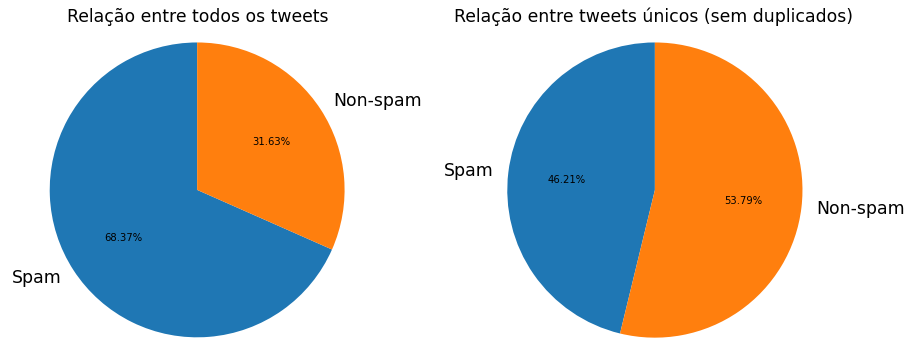

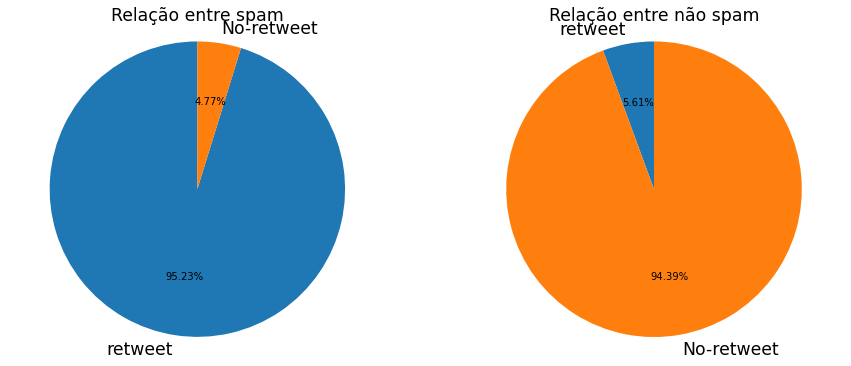

In [60]:
labels = 'Spam', 'Non-spam'
description = ["Relação entre todos os tweets", "Relação entre tweets únicos (sem duplicados)"]
b = bolso_df_copy
pie_chart_tweets(b, b.drop_duplicates(subset="Tweet"), "Type", "Spam", "Quality", labels, description)

labels = 'retweet', 'No-retweet'
description = ["Relação entre spam", "Relação entre não spam"]
b = bolso_df_copy
pie_chart_tweets(b[b["Type"] == "Spam"], b[b["Type"] == "Quality"], "is_retweet", 1, 0, labels, description)

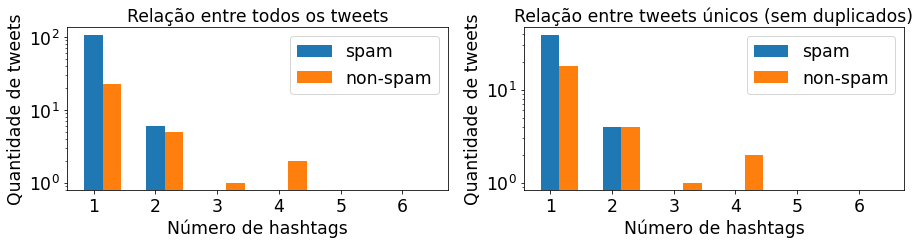

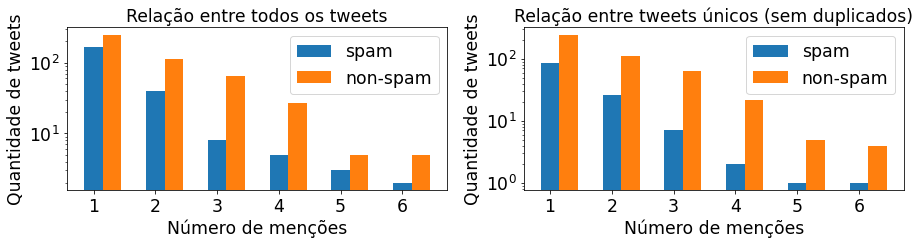

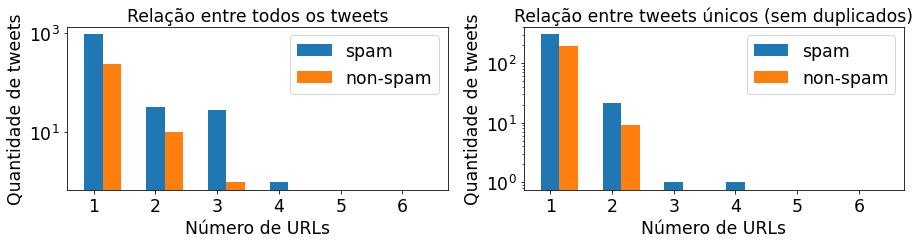

In [61]:
#grafico do teste followers/following
limit = np.arange(1, 7, 1)
get_col_counts_plot(bolso_df_copy, limit, 'hashtags', "Número de hashtags")
limit = np.arange(1, 7, 1)
get_col_counts_plot(bolso_df_copy, limit, 'mentions', "Número de menções")
limit = np.arange(1, 7, 1)
get_col_counts_plot(bolso_df_copy, limit, 'URLs', "Número de URLs")

In [62]:
def show_ranking(df, info, func, all):
    spam_hashtags = get_all_infos(df, "Spam", func)
    quality_hashtags = get_all_infos(df, "Quality", func)

    top_spam = get_ranking(spam_hashtags, 5, [info, "Quantidade"])
    top_quality = get_ranking(quality_hashtags, 5, [info, "Quantidade"])

    print(f"Top 5 {info} in spam and non-spam tweets")
    print(f"{all} tweets:")
    return pd.concat([d.reset_index(drop=True) for d in [top_spam, top_quality]], axis=1)

In [63]:
show_ranking(bolso_df_copy, "Hashtags", find_hashtag, "All")

Top 5 Hashtags in spam and non-spam tweets
All tweets:


,Hashtags,Quantidade,Hashtags,Quantidade
0,#MissGrandInternational,45,#ForaBolsonaro,4
1,#BolsonaroNuncaMais,7,#PTNuncaMais,2
2,#LulaEoPTMulheresComDireitos,7,#GrandLorena,2
3,#ForaBolsonaro,6,#STF,2
4,#tacladuran,5,#LulaLadrao,2


In [64]:
unique_tweets = bolso_df_copy.drop_duplicates(subset="Tweet")
show_ranking(unique_tweets, "Hashtags", find_hashtag, "Unique")

Top 5 Hashtags in spam and non-spam tweets
Unique tweets:


,Hashtags,Quantidade,Hashtags,Quantidade
0,#MissGrandInternational,6,#ForaBolsonaro,3
1,#ForaBolsonaro,4,#PTNuncaMais,2
2,#BolsonaroNuncaMais,3,#STF,2
3,#LulaEoPTMulheresComDireitos,3,#LulaLadrao,2
4,#LulaNoPodpah,2,#MoroTraidor,1


In [65]:
show_ranking(bolso_df_copy, "URLs", find_url, "All")

Top 5 URLs in spam and non-spam tweets
All tweets:


,URLs,Quantidade,URLs,Quantidade
0,https://twitter.com/Jouberth19/status/14671085...,48,https://www.youtube.com/channel/UCGfNDjbkEK89D...,16
1,https://twitter.com/PATRlOTAS/status/146714514...,48,https://twitter.com/Simonycorredora/status/146...,4
2,https://uca97b68da57b4d006d7f74f789b.dl.dropbo...,28,https://twitter.com/phvitoria1/status/14553239...,3
3,https://t.me/desmentindobozo,28,https://pleno.news/brasil/eleicoes-2022/partid...,2
4,https://twitter.com/desmentindobozo/status/146...,28,https://twitter.com/Simonycorredora/status/146...,2


In [66]:
unique_tweets = bolso_df_copy.drop_duplicates(subset="Tweet")
show_ranking(unique_tweets, "URLs", find_url, "Unique")

Top 5 URLs in spam and non-spam tweets
Unique tweets:


,URLs,Quantidade,URLs,Quantidade
0,https://twitter.com/Jouberth19/status/14671085...,1,https://www.youtube.com/channel/UCGfNDjbkEK89D...,16
1,https://www.brasil247.com/regionais/sudeste/ra...,1,https://twitter.com/phvitoria1/status/14553239...,2
2,https://revistaoeste.com/politica/partido-de-b...,1,https://twitter.com/Marcia06513945/status/1467...,1
3,https://revistaoeste.com/politica/bolsonaro-af...,1,https://www1.folha.uol.com.br/equilibrioesaude...,1
4,https://terrabrasilnoticias.com/2021/12/michel...,1,https://www.youtube.com/watch?v=7wNCmZuw0aw&fe...,1
